<a href="https://colab.research.google.com/github/liuchenbaidu/colab_code/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [2]:
!pip install tensorflow==1.15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 23 kB/s 
     |████████████████████████████████| 503 kB 53.3 MB/s 
     |████████████████████████████████| 3.8 MB 42.4 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=111df7e13f07a3631dc83d85d0fdc148c5f578e70217e8c97c60b6dce32325c1
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting un

In [3]:
import tensorflow as tf
tf.__version__

'1.15.0'

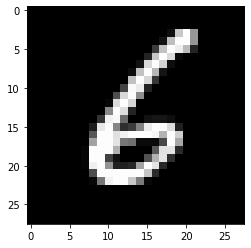

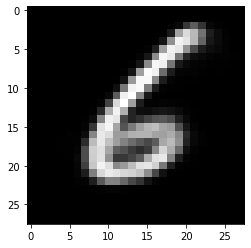

27200 26.601929 16.206638 10.395288


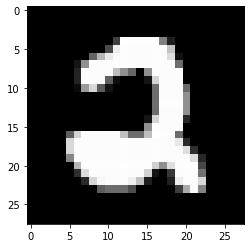

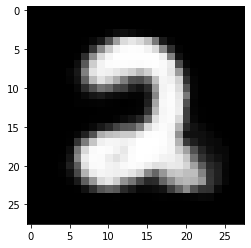

27400 26.118755 15.119321 10.999436


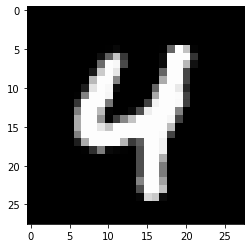

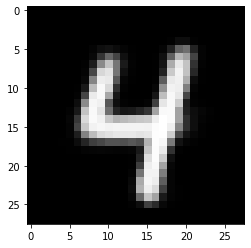

27600 28.110983 17.084824 11.026159


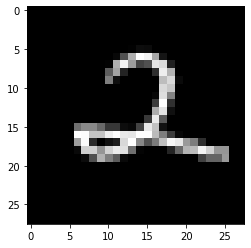

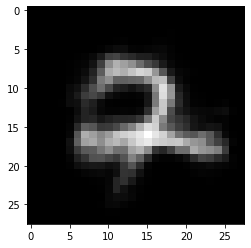

27800 27.745995 16.276588 11.469407


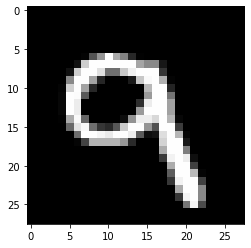

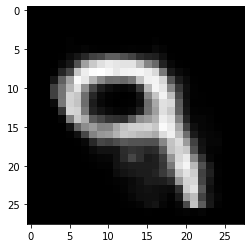

28000 25.839825 14.947059 10.892765


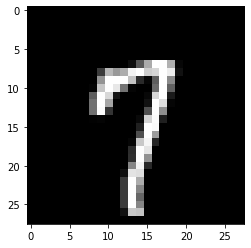

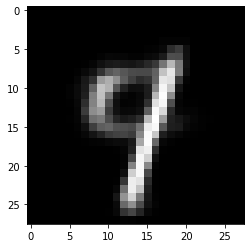

28200 27.575983 16.672304 10.90368


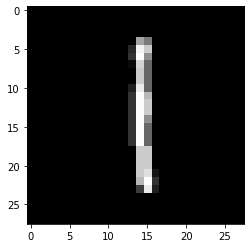

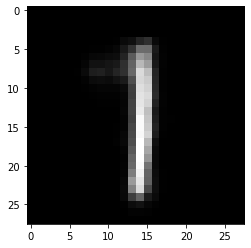

28400 26.00193 15.324715 10.677216


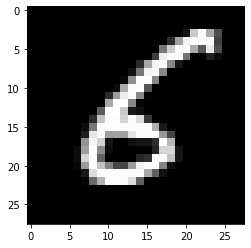

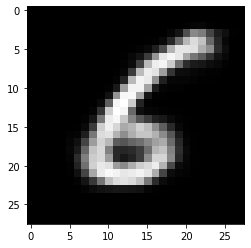

28600 26.242142 15.156073 11.08607


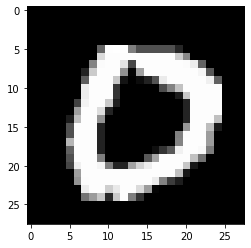

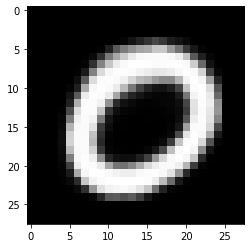

28800 26.52756 15.811014 10.716545


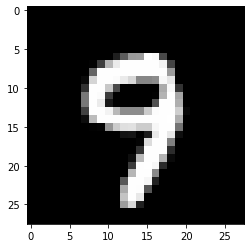

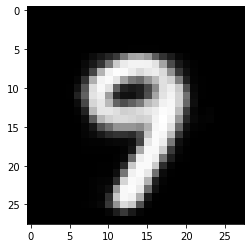

29000 25.993622 15.075277 10.918343


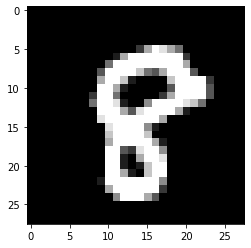

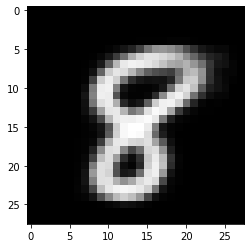

29200 28.724083 17.294464 11.429617


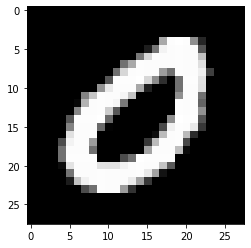

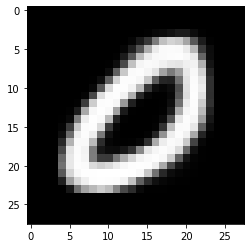

29400 28.552927 17.37026 11.182667


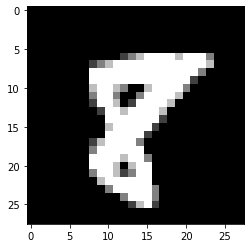

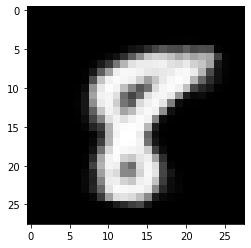

29600 28.168175 16.992785 11.175388


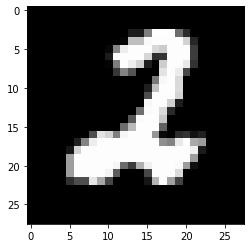

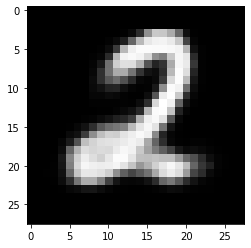

29800 28.202469 17.269188 10.933283


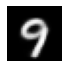

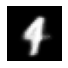

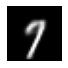

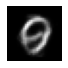

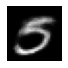

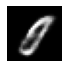

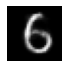

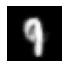

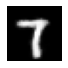

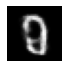

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data')#28*28的单色道图像数据

tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])#用于计算损失函数
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')#dropout比率

dec_in_channels = 1
n_latent = 8 #隐变量的维度设置

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels // 2


def lrelu(x, alpha=0.3):#自定义Leaky ReLU函数使效果更好
    return tf.maximum(x, tf.multiply(x, alpha))

#编码
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        
        #q(z|X)，需要通过一批次的X来随机的生成z（z的条件分布也需要不断学习）
        mn = tf.layers.dense(x, units=n_latent) #利用计算means
        sd       = 0.5 * tf.layers.dense(x, units=n_latent) #利用计算standard         
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) #从正态分布中采样
        z  = mn + tf.multiply(epsilon, tf.exp(sd)) 
        return z, mn, sd

#解码
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        #还原成28x28
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

#结合
sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

#损失函数的计算由两部分组成
unreshaped = tf.reshape(dec, [-1, 28*28])
#最大似然
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
#KL散度
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(30000):#开始训练
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
        
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

#单独拿出来可以用于生成新的字符
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

